# 本章節目標:用numpy.手刻神經網絡!!!

# 1.利用數值微分方法，找到函數的微分 (偏微分) 解


In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

   ##    (1)先定義一個簡單的方程式：  $ f(x) = 0.01x^2 + 0.1x $

In [0]:
# Define a target function
def my_function(x):
    # y = 0.01x^2 + 0.1x
    return 0.01*x**2 + 0.1*x

## (2)再來定義微分公式：$ \frac{df(x)}{dx} =\lim\limits_{h\to 0} \frac{(f(x+h) - f(x))}{h} $

In [0]:
# Wrong Example(h is too small to compute)
def numerical_diff_wrong(f, x):
    h = 10e-50
    return (f(x+h) - f(x)) / h

# Correct Example 1
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x)) / h

# Correct Example 2
def numerical_diff_2(f, x):
    h = 1e-4
    return ( f(x+h) - f(x-h) ) / (2 * h)



## (3)計算方程式在5和10的微分值

In [0]:
print("--Wrong Example--")
print('The derivative of x at 5 is',numerical_diff_wrong(my_function, 5))
print('The derivative of x at 10 is',numerical_diff_wrong(my_function, 10))
print('*****************************************************')
print("--Correct Example 1--")
print('The derivative of x at 5 is',numerical_diff(my_function, 5))
print('The derivative of x at 10 is',numerical_diff(my_function, 10))
print('*****************************************************')
print("--Correct Example 2--")
print('The derivative of x at 5 is',numerical_diff_2(my_function, 5))
print('The derivative of x at 10 is',numerical_diff_2(my_function, 10))

--Wrong Example--
The derivative of x at 5 is 0.0
The derivative of x at 10 is 0.0
*****************************************************
--Correct Example 1--
The derivative of x at 5 is 0.20000099999917254
The derivative of x at 10 is 0.3000009999976072
*****************************************************
--Correct Example 2--
The derivative of x at 5 is 0.1999999999990898
The derivative of x at 10 is 0.2999999999986347


# 2.偏微分
$ y = x_0^2 + x_1^2 $

1) if $ x_0 = 3, x_1 = 4, \partial f / \partial x_0 = ? $

2) if $ x_0 = 3, x_1 = 4, \partial f / \partial x_1 = ? $

In [0]:
# Only example
# y = x0^2 + x1^2
def partial_derivative(x):
    return x[0]**2 + x[1]**2

# if x0 = 3, x1=4, ask: df/dx0
def par_dev_fun1(x0):
    return (x0**2) + (4 ** 2)

# if x0 = 3, x1=4, ask: df/dx1
def par_dev_fun2(x1):
    return (3 ** 2) + (x1**2)

print(numerical_diff(par_dev_fun1, 3))
print(numerical_diff(par_dev_fun2, 4))

6.000099999994291
8.00009999998963


# 3.梯度

$ x_0^2 + x_1^2 $

### 定義一個輸出為偏微分值陣列的function

In [0]:
'''easy way'''
def par(f,x): 
    d=1e-4
    ans=[]
   
    for i in range(len(x)):
        xp=x.copy()
        xm=x.copy()
        xp[i]=float(x[i])+d
        xm[i]=float(x[i])-d
        ans.append((f(xp)-f(xm))/(2*d))
    return ans
print(par(partial_derivative, np.array([3.0, 4.0])))
print(par(partial_derivative, np.array([3.0, 2.0])))
print(par(partial_derivative, np.array([0.0, 0.0])))

[6.0000000000037801, 7.9999999999991189]
[6.0000000000126619, 3.9999999999995595]
[0.0, 0.0]


### 但後面在deep learning時，我們的x是一個陣列(像是下面的簡單範例，x需要輸入二微陣列)

In [0]:

def two_dim_fun(x):
    return x[0][0]**2+x[1][0]**2+x[0][1]**2+x[1][1]**2
        #其實不過就是x_1~x_4的平方和，只是把x換成二維的表達方式，所以別覺得這範例很難


### 而上面簡易版的function "par"很明顯只能處理一維的x，所以我們必須小小更動一下我們的程式

In [0]:
''' for more dimamsion of x'''
def par(f,x): 
  
    d=1e-4
    
    shapex=x.shape
    x=x.reshape(-1) #在這步，我們將x攤平成一維的陣列
    
    grad = np.zeros_like(x)
    ans=[]
    for i in range(len(x)):
        xp=x.copy()
        xm=x.copy()
        xp[i]=x[i]+d
        xm[i]=x[i]-d
        xp=xp.reshape(shapex)
        xm=xm.reshape(shapex)
        grad[i] = ((f(xp)-f(xm))/(2*d))
    grad=grad.reshape(shapex)
    return grad
print(par(two_dim_fun, np.array([[3.0, 4.0],[1.0,2.0]])))
print(par(partial_derivative, np.array([3.0, 2.0])))
print(par(partial_derivative, np.array([0.0, 0.0])))

[[ 6.  8.]
 [ 2.  4.]]
[ 6.  4.]
[ 0.  0.]


### 而為了配合下面我們的neural network程式，則需使用np.nditer寫成以下形式(x始終指向同一個變數)

In [0]:
'''for more dimamsion of x'''
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite']) # a multi-dimensional iterator (to iterate over an array)
#     print(type(it))
    while not it.finished:
        idx = it.multi_index #多index(多維)
#         print(idx)
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
#         print(float(tmp_val) + h)
        fxh1 = f(x) # f(x+h)
        
        x[idx] = float(tmp_val) - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
#         print(grad[idx])
        x[idx] = tmp_val
        it.iternext()   
        
    return grad

print(numerical_gradient(two_dim_fun, np.array([[3.0, 4.0],[1.0,2.0]])))
print(numerical_gradient(partial_derivative, np.array([3.0, 2.0])))
print(numerical_gradient(partial_derivative, np.array([0.0, 0.0])))

[[ 6.  8.]
 [ 2.  4.]]
[ 6.  4.]
[ 0.  0.]


### ---try it---
請嘗試給定不同的數學方程式，利用上面我們寫出來的function計算偏微分值

### To visualize the curve: https://goo.gl/iXTXGc

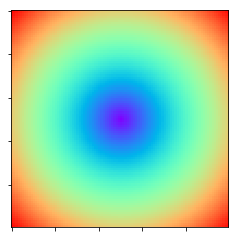

In [0]:
x=50
example_grad = np.zeros((2*x,2*x))
for i in np.arange(-x,x):
    for j in np.arange(-x,x):
        x_vec, y_vec = par(partial_derivative, np.array([np.float32(i), np.float32(j)]))
        net_vec = np.sqrt(x_vec**2 + y_vec**2)
        example_grad[i+x,j+x] = net_vec
plt.imshow(example_grad, cmap = 'rainbow')

frame1 = plt.gca() 
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])

plt.show()

$$ x^2 + y^2 $$
$$ x^2 - y^2 $$
![Image of gradient](https://mse.redwoods.edu/darnold/math50c/matlab/gradient/figure3.png)

# 4.Define two layers network

## (1)定義需要的function

### 1. sigmoid function : 
## $ \frac{1}{1+e^{-t}}$

In [0]:
# define activation: sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x)) 

### 2. softmax function :
#### for a K-dimensional vector ${\displaystyle \mathbf {z} }$ 
### $\sigma(\mathbf{z})_j = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}} \mbox{for j = 1, …, K}$ 

In [0]:
# define activation: softmax
def softmax(x):
    if x.ndim == 2:
        x = x.T # Transpose it
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    return np.exp(x) / np.sum(np.exp(x))

### iii. Cross entropy
#### $m$: batch size; for a given sample $i$, $p(x_i)=$ true distribution; $q(x_i)=$ predicted probability distribution
### $H(p,q)=-\displaystyle\sum _{i=1}^m \sum_{x_i} p(x_i)\,\log q(x_i).\!$
For example, suppose the true answer to a given sample $i$ is "$x_{i}=5$" and the probability for our model to predict "$x_i=5$" is only 0.05, then
#### $\sum_{x_i}p(x_{i})\,\log q(x_{i})=1\times \log 0.05 +0 \times \log (1-0.05)$
And if the answer to sample $j$ is "$x_{j}=8$" and the probability for getting "8" is 0.77, then
#### $\sum_{x_j}p(x_{j})\,\log q(x_{j})=1\times \log 0.77 +0 \times \log (1-0.77)$
### The final result is simply to get the mean of the cross entropy in a batch, i.e., $ \frac{1}{m}\,H(p,q)$

In [0]:
# define cross_entropy
def cross_entropy(y, t):
# y will catch the predict values, and t will catch the answers
    if y.ndim == 1:  
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    #這裡的意思是指，如果本來是一維陣列，我們強制把它看成1*n的二維陣列 (在batch size設為1時會用到)   
    if t.size == y.size:  
        t = t.argmax(axis=1)
        #將one-hot encoding 後的label重新轉回原來的樣子
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [0]:
t=np.array([[0.,1.],[1.,0.]])
y=np.array([[0.8,0.2],[0.2,0.8]])
cro=cross_entropy(y,t)
cro

1.6094374124342252

In [0]:

class Two_layerNet:
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 output_size, 
                 weight_init_std = 0.01):
        #------------------------------定義好要用的陣列與起始值---------------------------------
        self.params = {}
        self.params['w1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['w2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)


#------------------------------build network and predict---------------------------------
    def predict(self, x):
        # forward
        
        w1, w2 = self.params['w1'], self.params['w2']
        b1, b2 = self.params['b1'], self.params['b2']
        #hidden layer運算
        a1 = np.dot(x, w1) + b1 
        z1 = sigmoid(a1) #activation function
        #output layer運算
        a2 = np.dot(z1, w2) + b2
        y = softmax(a2) #activation function
        return y
#--------------------------lost function(with cross entropy)---------------        
    def loss(self, x, y_true):
        y_pred = self.predict(x)
        return cross_entropy(y_pred, y_true)
#----------------------------------accuracy---------------------------------    
    def compute_acc(self, x, y_true):
        y_pred = self.predict(x)
        # take argmax
        y_pred = y_pred.argmax(axis = 1) 
        y_true = y_true.argmax(axis = 1)
        
        acc = np.sum(y_pred == y_true) / len(y_true)
        return acc
#-----------------------------optimizer(gradient)---------------------------   
    def numerical_gradient(self, x, y_true):
        loss_W = lambda W: self.loss(x, y_true)#等同以下註解起來的寫法
#         def loss_W(W):
#             return self.loss(x,y_true)
        grads = {}
        #下面步驟看來直觀，但實際在理解卻又很容易卡在細節，這裡的self.params與上面範例不同，是去指向loss_W中所代表的Two_layerNet的self.params，而不是單純的給loss_W一個陣列。
        #所以我們在教numerical_gradient時才要用到np.nditer，為了確保我們在增加或減少一個極小值h時是對原來的self.params['']內的值做改變,而不是創建一個新的numpy陣列變數
        #然後去做改變，為了確保f(x)的x是指向原來的self.params['']。如果是創立了一個新的陣列(就是numerical_gradient function 與 par function的其中一個差異)而做計算，x會失去他身
        #為self.params的身分，只是個不相關的陣列，導致我們算出來的grads會等於零。
        grads['w1'] = numerical_gradient(loss_W, self.params['w1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['w2'] = numerical_gradient(loss_W, self.params['w2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
       
        return grads

In [0]:
from sklearn.datasets import load_digits #這次所使用的範例dataset(數字手寫)
from sklearn.model_selection import train_test_split #分割訓練/測試資料集
from tqdm import tqdm #進度條
import time

'''-----------------------------------資料前處理---------------------------------------------'''
digits = load_digits()
x_, y_ = digits.data, digits.target


#---------將資料做One-Hot Encoding---------
y_one_hot = np.zeros((len(y_), 10))
y_one_hot[np.arange(len(y_)), y_] = 1

#---------one way of normalization--------
x_ = x_ / x_.max() # normailze it to 0 - 1

#----------------------------資料training set, testing set 分割---------------------------------------
x_train, x_test, y_train, y_test = train_test_split(x_, y_one_hot, test_size = 0.1, stratify = y_)
'''--------------------------------建立List準備用來存過程中的acc與loss變化-------------------------'''
# define training settings ------------
train_loss_list = []
train_acc_list = []
test_acc_list = []

'''-----------------------------------參數設定與創建新模型--------------------------------------------'''
iters_num = 5001
train_size = x_train.shape[0] # numbers of training samples
bz = 100 # batch size
lr = 0.1 # learning rate


network = Two_layerNet(input_size=64, hidden_size=25, output_size=10)

'''-----------------------------------start training---------------------------------------------'''
starttime=time.time()
for i in tqdm(range(iters_num)):
    batch_mask = np.random.choice(train_size, bz)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = network.numerical_gradient(x_batch, y_batch) # already contain a feed-forward processing in this step
    
    for key in ("w1", "b1", "w2", "b2"):
        network.params[key] -= lr * grad[key] #更新參數
        
    this_loss = network.loss(x_batch, y_batch)
    train_loss_list.append(this_loss)
    
   #每執行100次紀錄一次 
    if i % 100 == 0:
        # compute accuracy for every 100 updates
        train_acc = network.compute_acc(x_train, y_train)#計算每個training set的 acc
        test_acc = network.compute_acc(x_test, y_test)#記算每個testing set的 acc
        
        train_acc_list.append(train_acc)#記錄每個training set的 acc
        test_acc_list.append(test_acc)#記錄每個testing set的 acc
        
timerange=time.time()-starttime                
print('總共費時：',timerange)       


  1%|          | 41/5001 [00:24<49:13,  1.68it/s]

KeyboardInterrupt: 

## 警告!!!覺得等太久了請趕緊按上面的停止鍵停止運行，因為跑完真的會花很久的時間!!!!(不影響圖形化，運行多久畫多少圖)

## 接著我們將結果圖形化

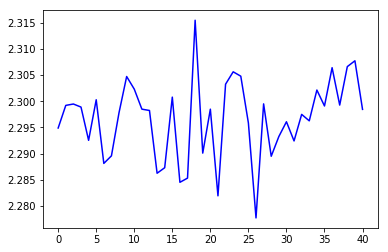

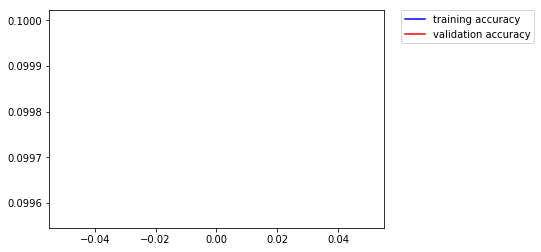

In [0]:
'''-----------------------------------圖形化---------------------------------------------'''  
#------------------------------------------------------plot------------------------------------------------------
#print("Train accuarcy, Test accuracy | " + str(train_acc) + ", " + str(test_acc))
    
#lose圖
plt.plot(np.arange(len(train_loss_list)), train_loss_list, 'b-')
plt.show()

#training/validation accuracy圖
plt.plot(np.arange(len(train_acc_list)), train_acc_list, 'b-', label = 'training accuracy')
plt.plot(np.arange(len(test_acc_list)), test_acc_list, 'r-', label = 'validation accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# 覺得要跑超久的對吧.....覺得不會?那你可能是剛入門以為這個範例真要跑這麼久!!
# 下個章節BP，讓你知道你剛剛浪費了多少時間!